In [ ]:
# Explanation of prediction output when activation is sigmoid:
# https://forum.freecodecamp.org/t/model-predict-output/470349

import tensorflow as tf
import tensorflow_datasets as tfds
import logging, os
import pandas as pd
import time
from tensorflow.keras.models import load_model
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"cats_vs_dogs/"
os.system("mkdir -p " + OUTPUT_PATH)

In [2]:
import tensorflow_datasets as tfds

DATA_PATH = "../../../../../local_data/datasets/animals/"
# Initialize the ImageFolder dataset
builder = tfds.ImageFolder(DATA_PATH)

# Print dataset information
print(builder.info)  # This will show the number of examples, labels, etc.

# Create the dataset
# test_dataset = builder.as_dataset(
#     split='test',
#     shuffle_files=True
# )
(train_dataset, test_dataset) = builder.as_dataset(
    split=['train', 'test'],
    shuffle_files=True
)

print(f"Number of test samples: {test_dataset.cardinality()}")

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='../../../../../local_data/datasets/animals/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=7, num_shards=1>,
        'train': <SplitInfo num_examples=7, num_shards=1>,
    },
    citation="""""",
)
Number of test samples: 7


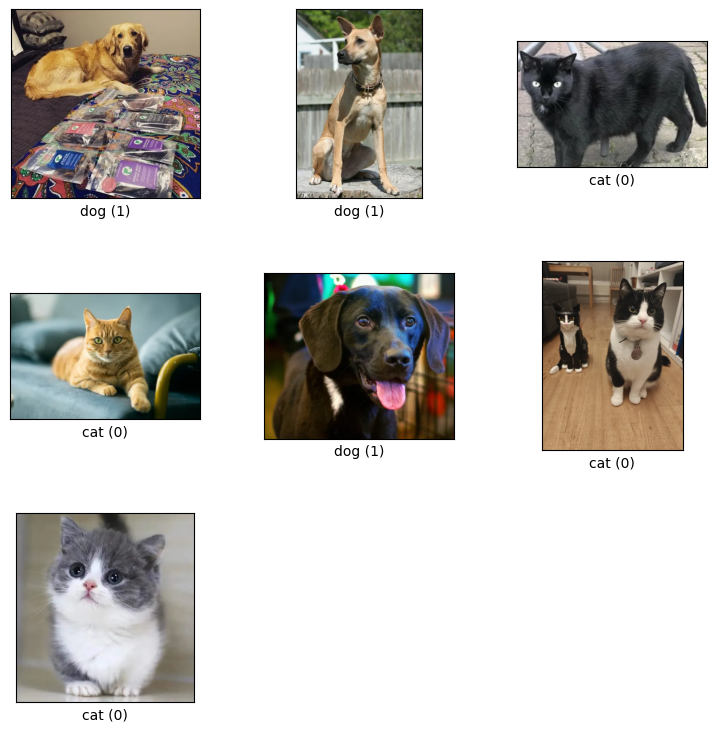

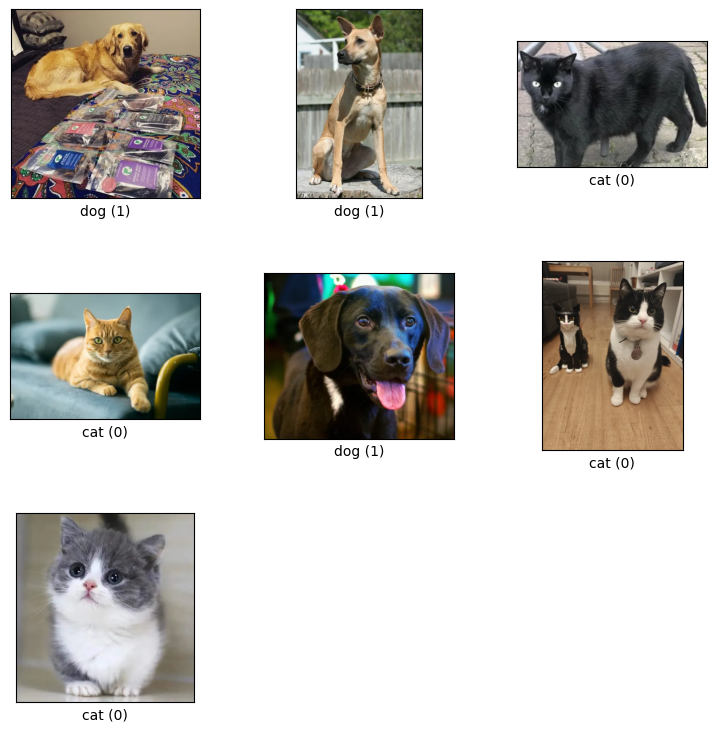

In [3]:
# Display examples
tfds.show_examples(test_dataset, builder.info)

In [4]:
# Preprocess the data
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0
    return image, label

# train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

batch_size = 64
# train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)

# Load model
filename = "valacc_0.641_epochs_10_date_20250719-150250.h5"

fullpath = f"{OUTPUT_PATH}{filename}"
model = load_model(fullpath)
model.summary()


# Make predictions
predictions = model.predict(test_dataset)
allpreds=predictions.flatten()
allpnorms = np.where(allpreds > 0.5, 1, 0)

alllabels=np.empty(0)
for images, labels in test_dataset:
    alllabels = np.append(alllabels, labels.numpy().flatten())

score = metrics.accuracy_score(alllabels, allpnorms)
print("Validation accuracy score: {}".format(score))

collabels = pd.DataFrame(alllabels, columns=["l"])
colpreds = pd.DataFrame( allpreds, columns=["pred"])
pnorm = pd.DataFrame( allpnorms, columns=["pnorm"])
diff = collabels["l"] - pnorm["pnorm"]

compare = pd.concat([collabels, colpreds,pnorm,diff], axis=1)
compare.columns = ["l", "pred", "pnorm","diff"]
print(compare)

compare.to_csv(OUTPUT_PATH + "pred_test_load.csv", index=False)    

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__preprocess() missing 1 required positional argument: 'label'


In [ ]:
# Load the dataset
(train_dataset, test_dataset), metadata = tfds.load(
    'cats_vs_dogs',
    data_dir=DATA_PATH,
    # split=['train[:80%]', 'train[80%:]'],
    split=['train[:80%]', 'train[99%:]'],
    with_info=True,
    as_supervised=True
)
number_of_images=10
allcorrect = (allpnorms == alllabels)

new_df=tfds.as_dataframe(test_dataset.take(number_of_images), metadata)
# new_df
new_df['predictions'] = allpreds[0:number_of_images]
new_df['pred norm'] = allpnorms[0:number_of_images]
new_df['correct'] = allcorrect[0:number_of_images]
new_df